In [1]:
import numpy as np
import os
import json
import jax
import jax.numpy as jnp
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import corner

import qnmfits
from funcs.CCE import SXS_CCE
from funcs.GP_funcs import get_inv_GP_covariance_matrix, compute_kernel_matrix, kernel_main

from power_law_tail_fits_jax import QNM_PLT_BAYES_FIT, get_analysis_times, get_cov_inverse

In [2]:
id = '0004'

with open('tuned_params.pkl', 'rb') as f:
    params = pickle.load(f)
tuned_param_dict_main = params[id]

def get_GP_covariance_matrix(analysis_times, kernel, tuned_param_dict, spherical_modes=None):
    if spherical_modes == None:
        spherical_modes = tuned_param_dict.keys()
    kernel_dict = {
        mode: compute_kernel_matrix(analysis_times, tuned_param_dict[mode], kernel)
        for mode in spherical_modes
    }

    return np.array([kernel_dict[mode] for mode in spherical_modes])


In [3]:
sim = SXS_CCE(id, lev="Lev5", radius="R2")

spherical_modes = [(2,2), (3,2), (4,4), (5,4), (6,6)]

In [4]:
def get_linear_qnm_fit(sim, spherical_modes, t0, T,
                       kernel, tuned_param_dic, **kwargs):
    
    threshold = 0.9

    overall_n_max = 7

    n_max = {s: 0 for s in spherical_modes}
    modes = [(*s, 0, 1) for s in spherical_modes]

    times, _ = get_analysis_times(sim, t0, T)

    inv_noise_covs = get_cov_inverse(get_GP_covariance_matrix(
                                            times, 
                                            kernel, 
                                            tuned_param_dic, 
                                            spherical_modes=spherical_modes))

    stop = False
    while not stop:

        possible_new_modes = []
        for s in spherical_modes:
            if n_max[s]+1 <= overall_n_max:
                possible_new_modes.append((s[0], s[1], n_max[s]+1, 1))
        if not (2,2,0,1,2,2,0,1) in modes:
            possible_new_modes.append((2,2,0,1,2,2,0,1))
        if not (2,2,0,1,2,2,0,1,2,2,0,1) in modes:
            possible_new_modes.append((2,2,0,1,2,2,0,1,2,2,0,1))

        if len(possible_new_modes) == 0:
            print("Stopping: no more modes to add.")
            print("Final mode content", modes)
            stop = True
            break

        log_significance = {}
        for new_mode in possible_new_modes:
            try_modes = modes.copy() + [new_mode]
            trial_fit = QNM_PLT_BAYES_FIT(sim, try_modes, spherical_modes, t0, T, inv_noise_covs, **kwargs)
            log_significance[new_mode] = trial_fit.log_significance(new_mode)

        max_logS = max(log_significance.values())

        if max_logS < np.log(threshold):
            print("Stopping: no more significant modes")
            print("Final mode content", modes)
            stop = True
            break

        mode_to_add = max(log_significance, key=log_significance.get)
        print(f"Adding mode {mode_to_add} with log-significance {max_logS}.")
        modes.append(mode_to_add)
        if len(mode_to_add)==4:
            n_max[(mode_to_add[0], mode_to_add[1])] += 1

    fit = QNM_PLT_BAYES_FIT(sim, modes, spherical_modes, t0, T, inv_noise_covs, **kwargs)

    return fit, modes


In [5]:
t0_vals = np.arange(0, 60.1, 1)

for t0 in t0_vals:
    if not os.path.isfile(f'mode_content_lists_'+str(id)+f'/t0_{t0}.json'):
        print(f'Fitting from {t0=}')
        T = 150 - t0
        fit, modes = get_linear_qnm_fit(sim, spherical_modes, t0, T, kernel_main, tuned_param_dict_main)
        with open(f'mode_content_lists_'+str(id)+f'/t0_{t0}.json', 'w') as f:
            json.dump(modes, f)

In [6]:
modes = {}
for t0 in t0_vals:
    with open(f'mode_content_lists_'+str(id)+f'/t0_{t0}.json', 'r') as f:
        modes[int(t0)] = json.load(f)

In [7]:
def masks(mode, modes):
    # Original mask
    mask = np.array([list(mode) in modes[int(t0)] for t0 in t0_vals])

    # Step 1: Identify changes
    changes = np.diff(mask.astype(int)) 

    # Step 2: Start and end indices
    start_indices = np.where(changes == 1)[0] + 1
    end_indices = np.where(changes == -1)[0] + 1

    # Handle edge case: mask starts or ends with True
    if mask[0]:
        start_indices = np.insert(start_indices, 0, 0)
    if mask[-1]:
        end_indices = np.append(end_indices, len(mask))

    # Step 3: Extract each run into a list of masks
    true_runs = []
    for start, end in zip(start_indices, end_indices):
        run_mask = np.zeros_like(mask, dtype=bool)
        run_mask[start:end] = True
        true_runs.append(run_mask)

    return true_runs

In [8]:
import seaborn as sns
colors = sns.color_palette("Set2", 7)

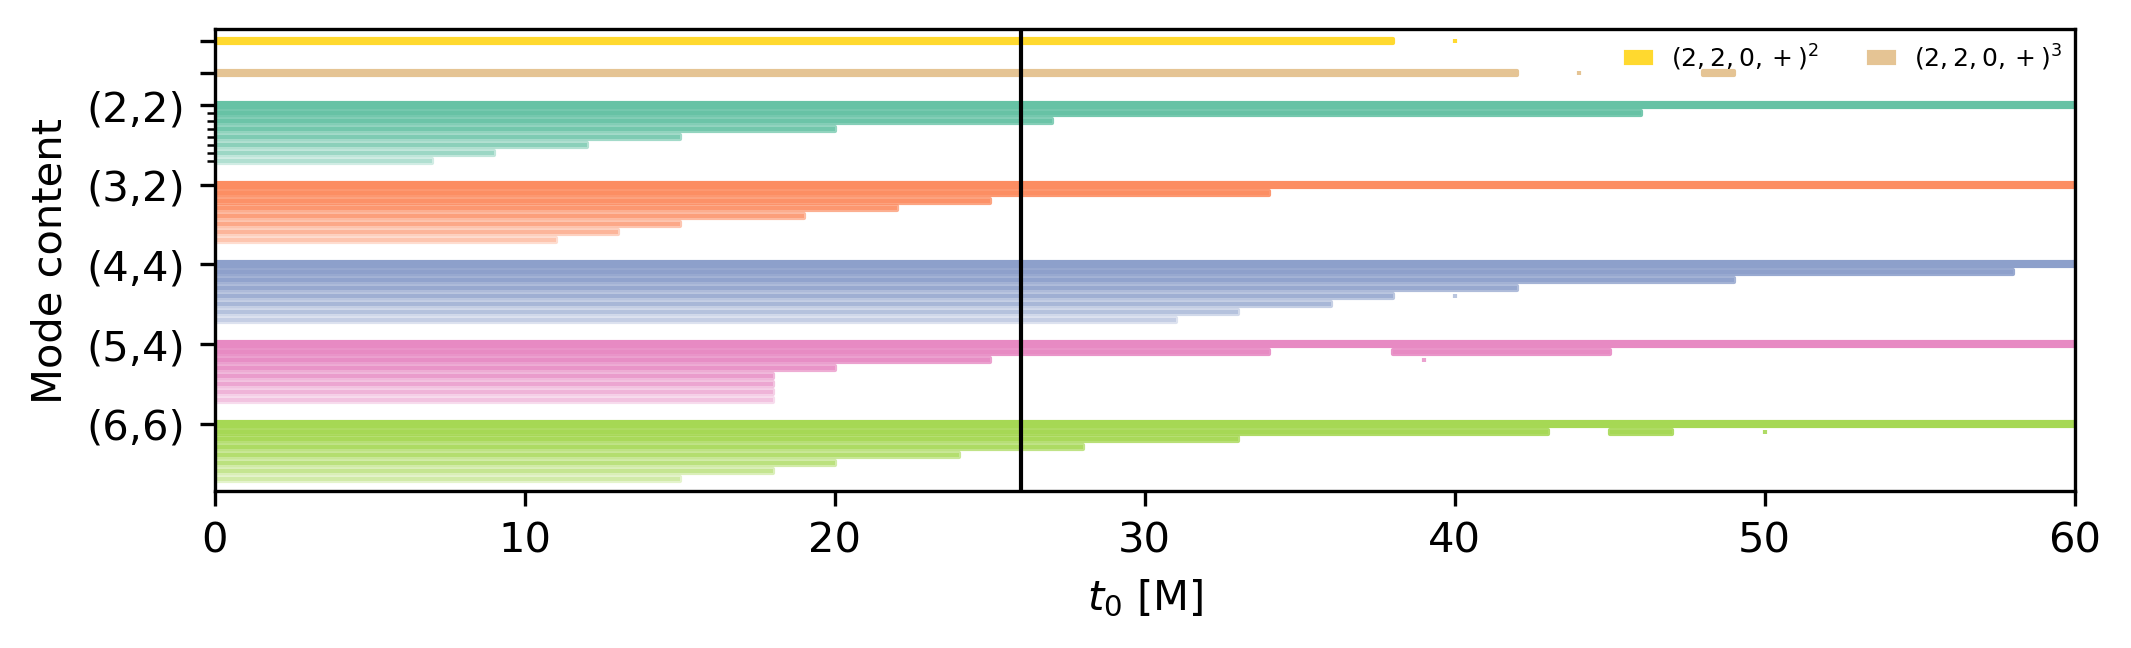

In [9]:
from matplotlib.ticker import FixedLocator

tref = {'0001': 17.0, '0002': 21.0, '0003': 23.0, '0004': 26.0}

eps = 0.25

sns.color_palette()

fig, ax = plt.subplots(figsize=(8, 2), dpi=300)

all_modes = ( [(2,2,n,1) for n in range(0, 8)] + \
              [(3,2,n,1) for n in range(0, 8)] + \
              [(4,4,n,1) for n in range(0, 8)] + \
              [(5,4,n,1) for n in range(0, 8)] + \
              [(6,6,n,1) for n in range(0, 8)] + \
              [(2,2,0,1,2,2,0,1)] + \
              [(2,2,0,1,2,2,0,1,2,2,0,1)])

for mode in all_modes:

    l_max, n_max = 6, 7

    if len(mode) == 4:
        l, m, n, p = mode
        y = -(l-2) * 10 - n
    elif len(mode) == 8:
        l, m, n, p, L, M, N, P = mode
        y = 8
    elif len(mode) == 12:
        l, m, n, p, L, M, N, P, _, _, _, _ = mode
        y = 4

    runs = masks(mode, modes)
    
    for i, run in enumerate(runs):

        label = None
        if i==0:
            label = (None if len(mode)==4 else (r"$(2,2,0,+)^2$" if len(mode)==8 else r"$(2,2,0,+)^3$"))

        ax.fill_between(
            t0_vals[run],
            [y-eps for t0 in t0_vals[run]],
            [y-1+eps for t0 in t0_vals[run]],
            alpha=1-0.1*n,
            color=(colors[l-2] if len(mode)==4 else (colors[5] if len(mode)==8 else colors[6])),
            label=label
        )

ax.axvline(tref[id], color='k', linestyle='-', lw=1)

ax.set_xlabel(r"$t_0$ [M]")
ax.set_ylabel(r"Mode content")

ax.set_xlim(0, 60)
ax.set_ylim(-(l_max-2) * 10 - n_max - 2, 9)

ticks = [-0.5, -10.5, -20.5, -30.5, -40.5, 3.5, 7.5]
minor_ticks = [-1.5, -2.5, -3.5, -4.5, -5.5, -6.5, -7.5]
tick_labels = ["(2,2)", "(3,2)", "(4,4)", "(5,4)", "(6,6)", "", ""]

ax.set_yticks(ticks)
ax.yaxis.set_minor_locator(FixedLocator(minor_ticks))
ax.set_yticklabels(tick_labels)

ax.legend(loc='upper right', frameon=False, fontsize=6,
          bbox_to_anchor=(1., 1.), handlelength=1., handleheight=0.3,
          borderpad=0., labelspacing=0.5, ncol=2)

plt.show()

In [10]:
fits = {}
for t0 in t0_vals:

    T = 150 - t0

    times, _ = get_analysis_times(sim, t0, T)

    inv_noise_covs = get_cov_inverse(get_GP_covariance_matrix(
                                            times, 
                                            kernel_main, 
                                            tuned_param_dict_main, 
                                            spherical_modes=spherical_modes))
    
    select_modes = modes[int(t0)]
    select_modes = [tuple(mode) for mode in select_modes] 

    fits[int(t0)] = QNM_PLT_BAYES_FIT(sim, select_modes, spherical_modes, t0, T, inv_noise_covs,
                                      include_Mf=True, include_chif=True)

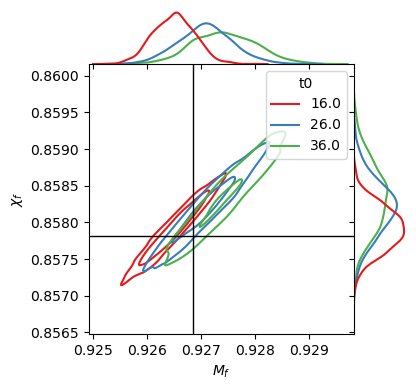

In [11]:
t1 = int(tref[id]-10)
t2 = int(tref[id])
t3 = int(tref[id]+10)

data = pd.DataFrame(data=np.hstack((fits[t1].samples['Mf'], 
                                    fits[t2].samples['Mf'], 
                                    fits[t3].samples['Mf'])),
                    columns=[r'$M_f$'])
data[r'$\chi_f$'] = np.hstack((fits[t1].samples['chif'], 
                          fits[t2].samples['chif'], 
                          fits[t3].samples['chif']))
data['t0'] = np.hstack((np.ones(len(fits[t1].samples['Mf']))*t1, 
                         np.ones(len(fits[t2].samples['Mf']))*t2, 
                         np.ones(len(fits[t3].samples['Mf']))*t3))

fig = sns.jointplot(data=data, x=r'$M_f$', y=r'$\chi_f$', hue='t0', kind="kde", space=0, 
                    height=4, joint_kws={'levels':[0.1, 0.5]}, 
                    palette=sns.color_palette("Set1", 3))

fig.ax_joint.axvline(sim.Mf, lw=1, color='k', ls='-')
fig.ax_joint.axhline(sim.chif_mag, lw=1, color='k', ls='-')

plt.show()


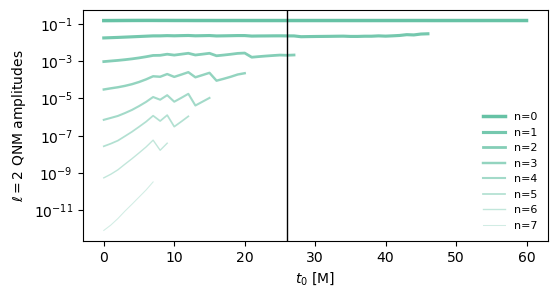

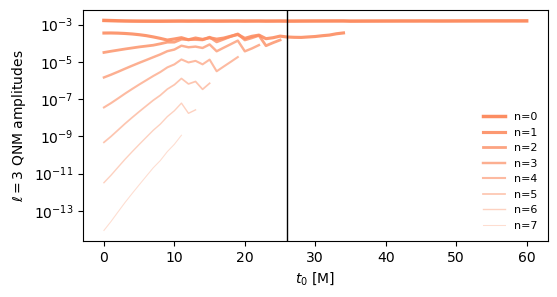

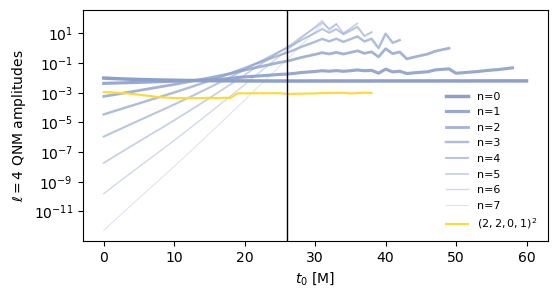

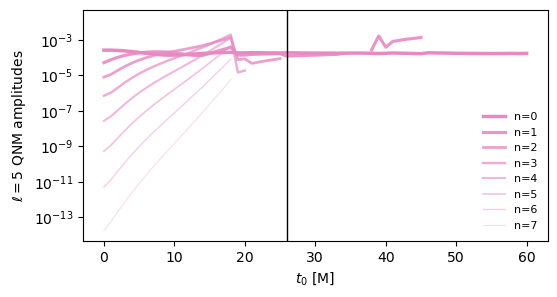

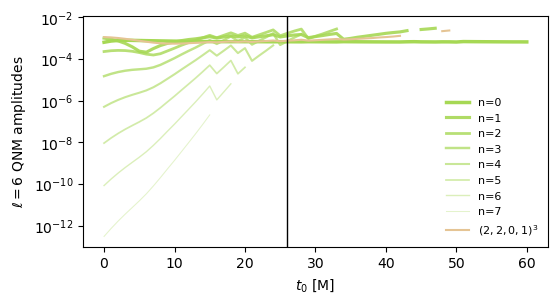

In [12]:
for l in range(2, 7):

    fig, ax = plt.subplots(figsize=(6, 3))

    for n in np.arange(8):

        mode = (l, l if l%2==0 else l-1, n, 1)

        runs = masks(mode, modes)

        for j, run in enumerate(runs):

            temp_t0_vals = t0_vals[run]

            amps = np.zeros_like(temp_t0_vals)
            for i, t0 in enumerate(temp_t0_vals):
                re = fits[t0].samples[f'Re C_{mode}']
                im = fits[t0].samples[f'Im C_{mode}']
                amps[i] = np.median(np.sqrt(re**2 + im**2))

            tau = qnmfits.qnm.omega(*mode, sim.chif_mag, Mf=sim.Mf).imag

            ax.plot(temp_t0_vals, amps*np.exp(-tau*(temp_t0_vals-tref[id])),
                    color=colors[l-2], alpha=1-0.1*n, lw=2.5-0.25*n,
                    label=f'{n=}' if j==0 else None)
            
    if l==4:
        mode = (2,2,0,1,2,2,0,1)
        runs = masks(mode, modes)
        for j, run in enumerate(runs):
            temp_t0_vals = t0_vals[run]
            amps = np.zeros_like(temp_t0_vals)
            for i, t0 in enumerate(temp_t0_vals):
                re = fits[t0].samples[f'Re C_{mode}']
                im = fits[t0].samples[f'Im C_{mode}']
                amps[i] = np.median(np.sqrt(re**2 + im**2))
            tau = 2*qnmfits.qnm.omega(2,2,0,1, sim.chif_mag, Mf=sim.Mf).imag
            ax.plot(temp_t0_vals, amps*np.exp(-tau*(temp_t0_vals-tref[id])),
                    color=colors[5], alpha=1, lw=1.5,
                    label=r'$(2,2,0,1)^2$' if j==0 else None)
            
    if l==6:
        mode = (2,2,0,1,2,2,0,1,2,2,0,1)
        runs = masks(mode, modes)
        for j, run in enumerate(runs):
            temp_t0_vals = t0_vals[run]
            amps = np.zeros_like(temp_t0_vals)
            for i, t0 in enumerate(temp_t0_vals):
                re = fits[t0].samples[f'Re C_{mode}']
                im = fits[t0].samples[f'Im C_{mode}']
                amps[i] = np.median(np.sqrt(re**2 + im**2))
            tau = 3*qnmfits.qnm.omega(2,2,0,1, sim.chif_mag, Mf=sim.Mf).imag
            ax.plot(temp_t0_vals, amps*np.exp(-tau*(temp_t0_vals-tref[id])),
                    color=colors[6], alpha=1, lw=1.5,
                    label=r'$(2,2,0,1)^3$' if j==0 else None)

    ax.set_xlabel(r"$t_0$ [M]")
    ax.set_ylabel(r"$\ell="+str(l)+"$ QNM amplitudes")

    ax.axvline(tref[id], lw=1, color='k', ls='-')

    ax.set_yscale('log')

    ax.legend(loc='lower right', frameon=False, fontsize=8)

    plt.show()

In [14]:
fits[0].qnm_model?

Object `fits[0].qnm_model` not found.
